## Graph Attention Networks on undirected graph

In [1]:
import sys
sys.path.insert(0, "../../")
from dataAnalysis.DataAnalysis import DataAnalysis
import pandas as pd
import numpy as np
import torch
 

data = pd.read_csv(r"../../extdata/sbcdata.csv", header=0)
data_analysis = DataAnalysis(data)

/home/dwalke/git/sbc/graph_learning/patient_centric/../../dataAnalysis/data/Filter.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Label'] = self.data['Diagnosis']
/home/dwalke/git/sbc/graph_learning/patient_centric/../../dataAnalysis/data/Filter.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Label'] = self.data['Diagnosis']
/home/dwalke/git/sbc/graph_learning/patient_centric/../../dataAnalysis/data/Filter.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy

## Sort data based on ID for matching edge index

In [2]:
data = pd.concat((data_analysis.get_training_data(), data_analysis.get_testing_data()))
max_Id = data["Id"].unique().max()
gw_data = data_analysis.get_gw_testing_data().copy(deep=True)
gw_data = gw_data.assign(Id=lambda x: x.Id + max_Id)
data = pd.concat((data, gw_data))
data = data.sort_values(["Id", "Time"])
data = data.reset_index(drop=True)
popped_index = data.pop("index")

## Reading edge index

In [3]:
edge_index = torch.tensor(pd.read_csv("edge_index/reverse_directed_edge_index.csv", header=None, skiprows=1).values.transpose(), dtype=torch.long)

## Pre-processing categorical variables

In [4]:
from dataAnalysis.Constants import SEX_CATEGORY_COLUMN_NAME, SEX_COLUMN_NAME, FEATURES
data[SEX_CATEGORY_COLUMN_NAME] = data.loc[:, SEX_COLUMN_NAME] =="W"

data[SEX_CATEGORY_COLUMN_NAME] = data[SEX_CATEGORY_COLUMN_NAME].astype("int8")
data["Label"] = data["Label"] == "Sepsis"
data["Label"] = data["Label"].astype("int8")

## Set features and labels

In [5]:
X_features = torch.tensor(data[FEATURES].values).type(torch.float32)
y = torch.tensor(data["Label"].values).type(torch.long)

## Normalize data

In [6]:
from dataAnalysis.FeatureImportance import normalize

X_features = normalize(X_features)

## Create train, validation and test masks

In [7]:
def ratio_bool_switch(tensor, ratio = 0.8):
    random = np.random.uniform(0, 1 ,tensor.shape[0])
    val_ratio_mask = (random >= 0.8)
    train_ratio_mask = (random < 0.8)
    val_mask = np.logical_and(tensor.tolist(), val_ratio_mask.tolist())
    train_mask = np.logical_and(tensor.tolist(), train_ratio_mask.tolist())
    return torch.from_numpy(train_mask).type(torch.bool), torch.from_numpy(val_mask).type(torch.bool)

In [8]:
train_mask_ser = data["Set"] != "Validation"
train_mask, val_mask = ratio_bool_switch(train_mask_ser.values)
test_mask = torch.from_numpy(np.logical_and((data["Set"] == "Validation").values, (data["Center"] == "Leipzig").values)).type(torch.bool)
test_gw_mask = torch.from_numpy(np.logical_and((data["Set"] == "Validation").values, (data["Center"] == "Greifswald").values)).type(torch.bool)

## Create patient-centric graph

In [18]:
from torch_geometric.data import Data

graph = Data(x=X_features, train_mask = train_mask, test_mask=test_mask, val_mask=val_mask, y= y, edge_index=edge_index,
             test_gw_mask = test_gw_mask).cpu()

## Create graph batches

In [54]:
from torch_geometric.loader import NeighborLoader

kwargs = {
    "num_neighbors":[-1] * 2,
    "batch_size":50_000,
}
loader = NeighborLoader(
    graph,
    input_nodes=graph.train_mask,
    shuffle=True,
    **kwargs
)
val_loader = NeighborLoader(
    graph,
    input_nodes=graph.val_mask,
    **kwargs
)

## Set device

In [55]:
device = torch.device("cuda:2") if torch.cuda.is_available() else torch.device("cpu")

graph = graph.to(device)
WEIGHT = torch.tensor([530])
WEIGHT = WEIGHT.to(device)

print("Data shifted to the device " + str(device))

Data shifted to the device cuda:2


## Define the model

In [110]:
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GCNConv,GATv2Conv, GINConv, SAGEConv
from dataAnalysis.Constants import FEATURES
from torch.nn import Linear, ReLU, Sequential
from torch.nn import BatchNorm1d as BatchNorm
import numpy as np

def glorot(shape):
    """Glorot & Bengio (AISTATS 2010) init."""
    init_range = np.sqrt(6.0/(shape[0]+shape[1]))
    initial_tensor = torch.FloatTensor(shape[0], shape[1]).uniform_(-init_range, init_range).type(torch.float32)
    return torch.nn.parameter.Parameter(data=initial_tensor, requires_grad=True)

class GraphNeuralNetwork(torch.nn.Module):
    def __init__(self, hidden_dim = 128, out_channels = 1):
        super(GraphNeuralNetwork, self).__init__()
        input_dim = len(FEATURES)      
        
        HEADS = 5
        
        conv_1= GATConv(input_dim, hidden_dim,heads=HEADS, add_self_loops = False)
        conv_end = GATConv(hidden_dim*HEADS, out_channels,add_self_loops = False)
        
        self.conv_1 = conv_1
        self.conv_end = conv_end
    
        
        self.conv_1.lin_src.weight = glorot(self.conv_1.lin_src.weight.shape)
        self.conv_1.lin_dst.weight = glorot(self.conv_1.lin_dst.weight.shape)
        self.conv_end.lin_src.weight = glorot(self.conv_end.lin_src.weight.shape)
        self.conv_end.lin_dst.weight = glorot(self.conv_end.lin_dst.weight.shape)
        
#         torch.nn.init.kaiming_normal_(self.conv_1.lin_src.weight, mode='fan_in', nonlinearity='relu')
#         torch.nn.init.kaiming_normal_(self.conv_1.lin_dst.weight, mode='fan_in', nonlinearity='relu')
#         torch.nn.init.kaiming_normal_(self.conv_end.lin_dst.weight, mode='fan_in')
#         torch.nn.init.kaiming_normal_(self.conv_end.lin_src.weight, mode='fan_in')
        torch.nn.init.zeros_(self.conv_1.bias)
        torch.nn.init.zeros_(self.conv_end.bias)        

    def forward(self, graph):
        x, edge_index = graph.x, graph.edge_index
        x = x.type(torch.float)
        x = self.conv_1(x, edge_index)
        x = F.normalize(x, p=2., dim=-1)
        x = torch.relu(x)
        x = self.conv_end(x, edge_index)
        return x
            
    def predict_proba(self, graph, mask):
        with torch.inference_mode():
            self.eval()
            logits = self.forward(graph)
            scores = torch.sigmoid(torch.squeeze(logits[mask]))
            scores = torch.unsqueeze(scores, 0)
            proba_predict = torch.concat((1- scores, scores), dim = 0)
            return torch.transpose(proba_predict, 0, 1)
            
    def predict(self, graph, mask):
        return torch.round(self.predict_proba(graph, mask)[:, 1])

## Model wrapper for training

In [111]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt 


class ModelWrapper():
    def __init__(self, train_loader, val_loader):
        self.LEARNING_RATE = 3e-4
        self.MAX_EPOCHS = 10000

        self.model = GraphNeuralNetwork(hidden_dim = 128, out_channels=1) 
        self.model = self.model.to(device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.LEARNING_RATE,betas=(0.9, 0.999), eps=1e-08)
        self.loader = train_loader
        self.val_loader = val_loader
        
        self.last_loss = 0
        self.increased_loss = 0
        self.BREAKING_THRESHOLD = 5
        self.val_loss = []
        self.train_loss = []
        self.epochs = self.MAX_EPOCHS
    
    
    def validate(self):
        with torch.inference_mode():
            self.model.eval()
            acc_loss = 0
            batch_size = 0
            for batch, graph in enumerate(self.val_loader):
                graph = graph.to(device)
                out = self.model(graph)
                loss = F.binary_cross_entropy_with_logits(torch.squeeze(out)[graph.val_mask], graph.y[graph.val_mask].type(torch.float32),
                                                          pos_weight=WEIGHT)
                acc_loss += loss.item()
                batch_size += 1
            avg_loss = acc_loss / batch_size
            self.val_loss.append(avg_loss)
            if avg_loss > self.last_loss:
                self.increased_loss += 1
            else:
                self.increased_loss = 0
            self.last_loss = avg_loss

    def train(self):
        for epoch in tqdm(range(self.MAX_EPOCHS)):
            acc_loss = 0
            batch_size = 0
            for batch, graph in enumerate(self.loader):
                graph = graph.to(device)
                self.model.train()
                self.optimizer.zero_grad()
                out = self.model(graph)
                loss = F.binary_cross_entropy_with_logits(torch.squeeze(out)[graph.train_mask], graph.y[graph.train_mask].type(torch.float32),
                                                          pos_weight=WEIGHT)
                acc_loss += loss.item()
                batch_size += 1
                loss.backward()
                self.optimizer.step()
            self.train_loss.append(acc_loss/batch_size)
            self.validate() 

            if self.increased_loss >= self.BREAKING_THRESHOLD:
                self.epochs = epoch + 1
                print(f"Breaked at {str(epoch)}")
                break
            
    def get_model(self):
        return self.model 
    
    def plot_loss(self):
        plt.plot(range(len(self.train_loss)), self.train_loss, 'g', label='Training loss')
        plt.plot(range(len(self.val_loss)), self.val_loss, 'y', label='Validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

## Train and plot loss curves

  0%|          | 0/10000 [00:00<?, ?it/s]

Breaked at 3713


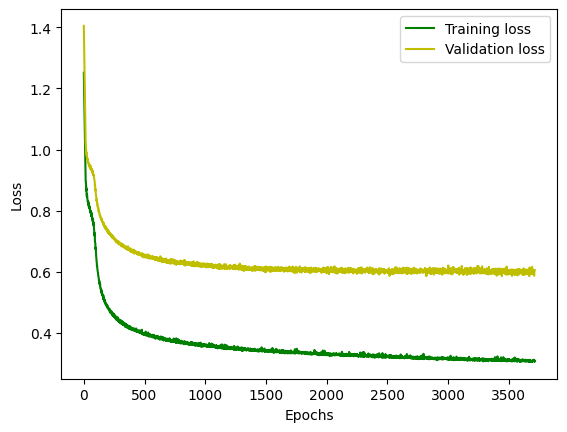

In [112]:
model_wrapper = ModelWrapper(loader, val_loader)
model_wrapper.train()
model_wrapper.plot_loss()

In [83]:
model.conv_end.state_dict()["lin_src.weight"]

tensor([[-1.5780, -1.5434, -1.6883, -1.9976, -2.2991, -2.3420, -1.9645, -3.2729,
         -1.5723, -1.9760,  2.3939,  2.8921,  2.3255, -2.2026, -1.7943, -3.3748,
         -1.7136, -2.7486, -1.7384,  2.9355, -2.4969, -3.4223, -2.0447,  1.5229,
          3.5167,  1.9984,  2.4622,  3.6565,  5.7000, -2.1497,  3.1076, -3.5604,
         -2.3556,  4.3021,  4.4496,  5.6841,  2.7946,  1.2639, -2.7069, -2.6465,
          2.6488, -1.6473, -1.6451, -2.5320, -2.1272,  2.8520, -3.3526,  2.7407,
          1.8579, -3.6415, -3.2507,  3.2104,  3.0934,  2.6187,  2.6459, -2.9730,
         -1.5943, -3.1705, -3.5720,  5.0068, -3.3105, -1.9569, -2.7706,  2.6120,
          6.3426, -1.7742, -2.6726,  1.8061,  4.9246, -2.5762, -1.7489, -3.6801,
          3.4355, -1.5915,  3.4458, -1.9782,  1.7089,  4.9225,  1.9317,  4.8204,
         -3.4539,  3.4806, -2.6860, -3.4179, -2.0756, -2.2780, -3.6783,  6.4105,
         -2.0785,  4.5581, -3.5724, -3.6003,  4.9316, -2.6670,  3.1976,  4.9483,
         -2.6672, -1.4444,  

## Error evaluation

In [115]:
import time

models = []
train_times = []
for i in range(10):
    model_wrapper = ModelWrapper(loader, val_loader)
    dra
    start = time.time()
    model_wrapper.train()
    
    train_times.append(time.time() - start)
    models.append(model_wrapper.get_model().cpu())

  0%|          | 0/10000 [00:00<?, ?it/s]

Breaked at 544


  0%|          | 0/10000 [00:00<?, ?it/s]

Breaked at 1398


  0%|          | 0/10000 [00:00<?, ?it/s]

Breaked at 1198


  0%|          | 0/10000 [00:00<?, ?it/s]

Breaked at 1314


  0%|          | 0/10000 [00:00<?, ?it/s]

Breaked at 1243


  0%|          | 0/10000 [00:00<?, ?it/s]

Breaked at 1801


  0%|          | 0/10000 [00:00<?, ?it/s]

Breaked at 733


  0%|          | 0/10000 [00:00<?, ?it/s]

Breaked at 643


  0%|          | 0/10000 [00:00<?, ?it/s]

Breaked at 956


  0%|          | 0/10000 [00:00<?, ?it/s]

Breaked at 2576


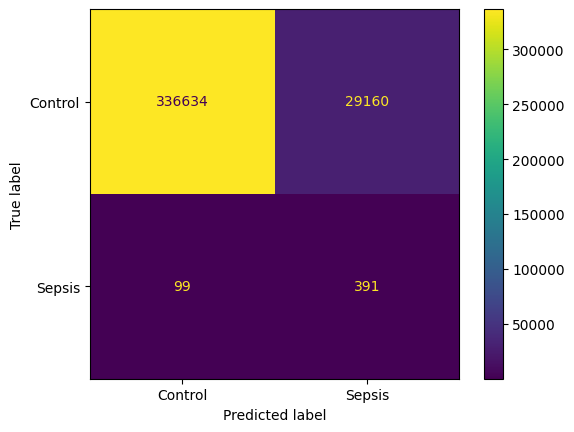

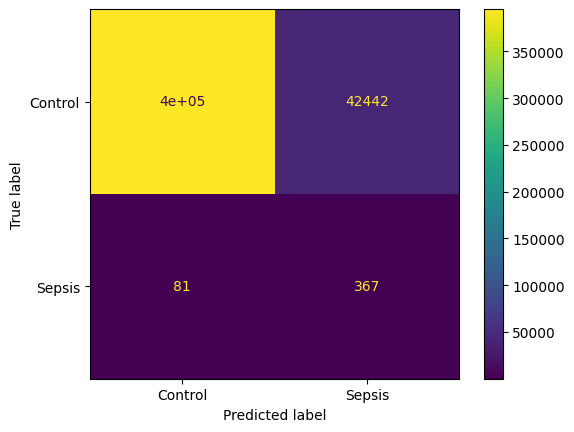

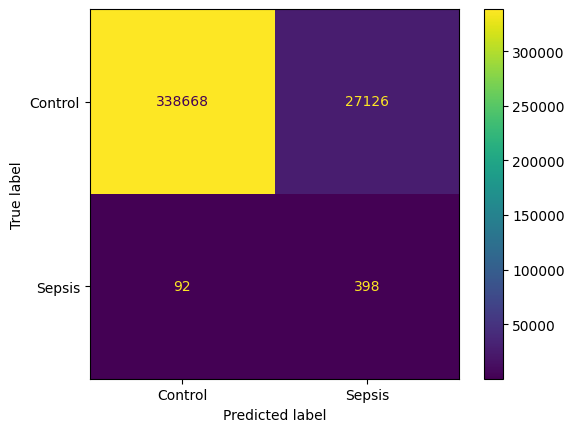

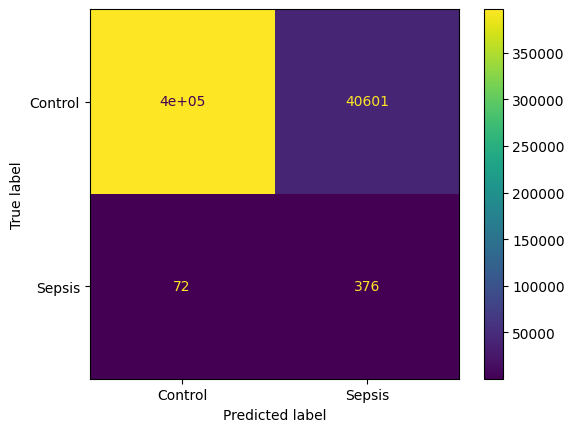

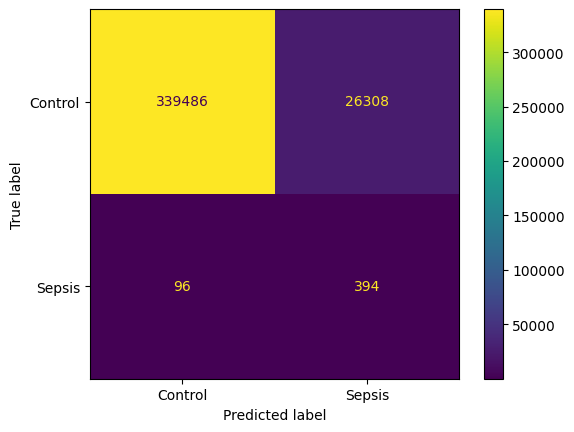

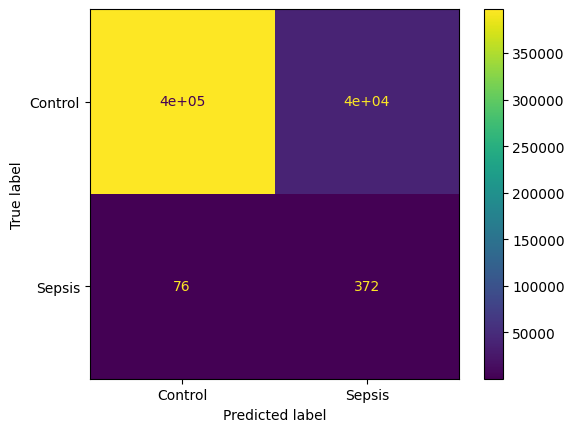

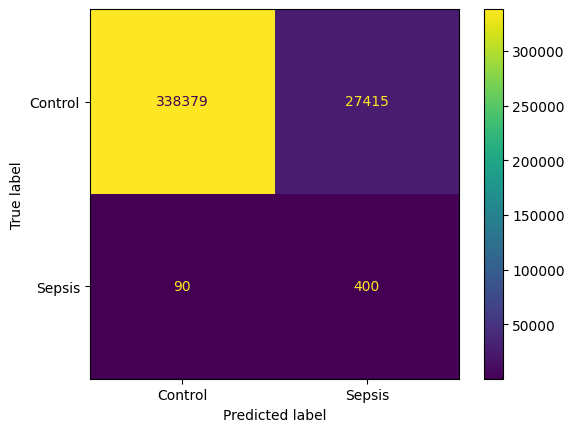

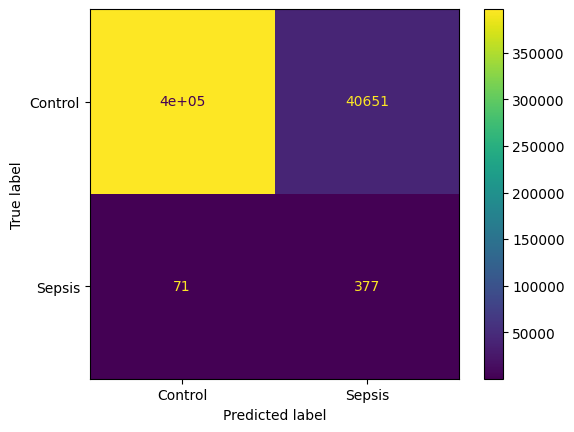

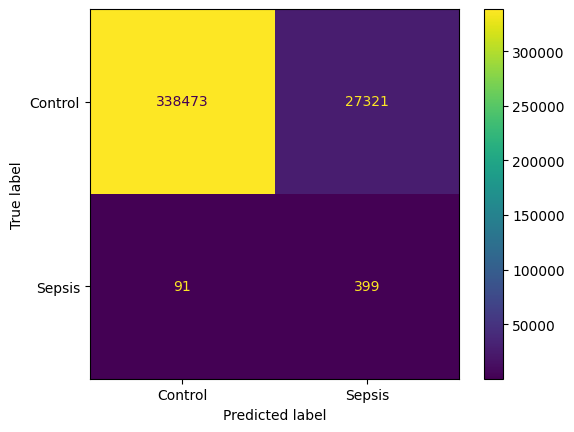

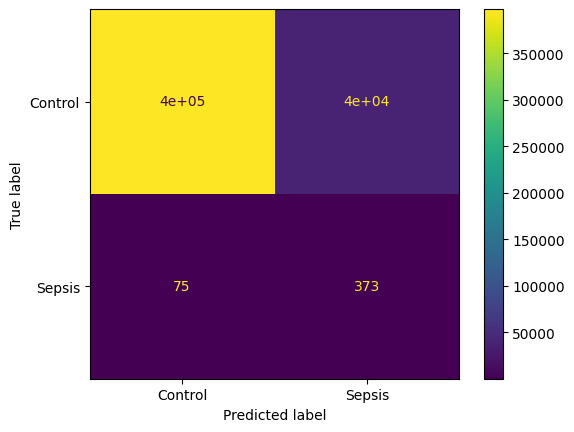

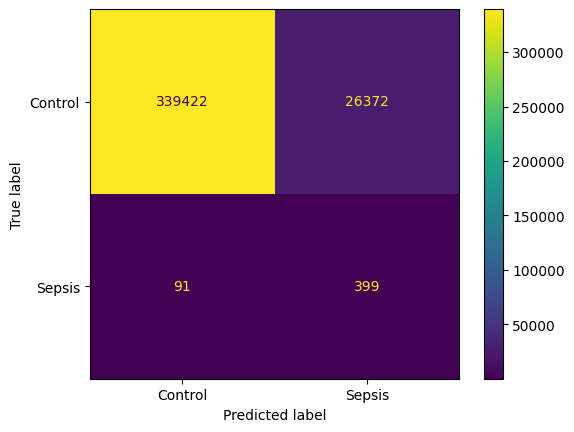

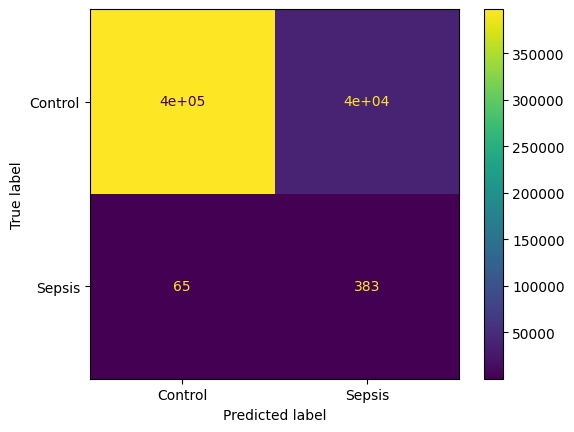

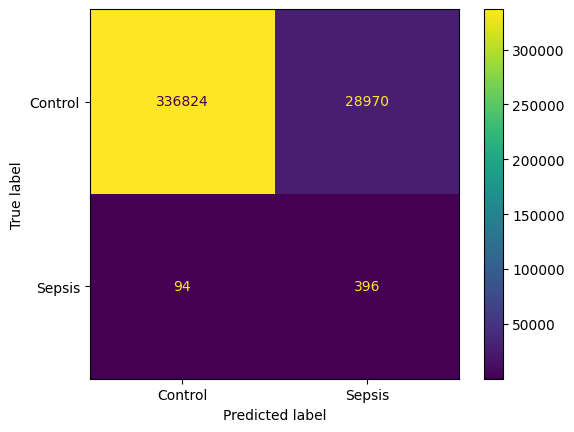

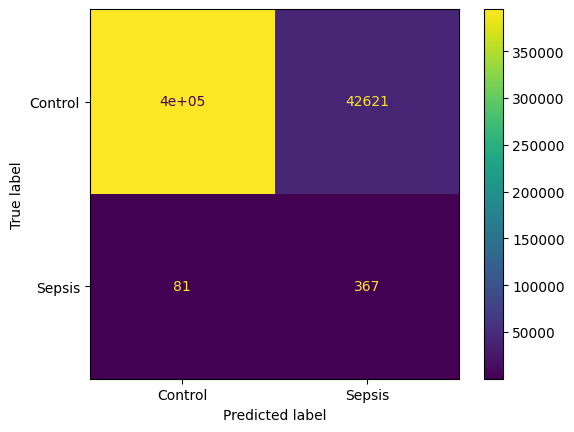

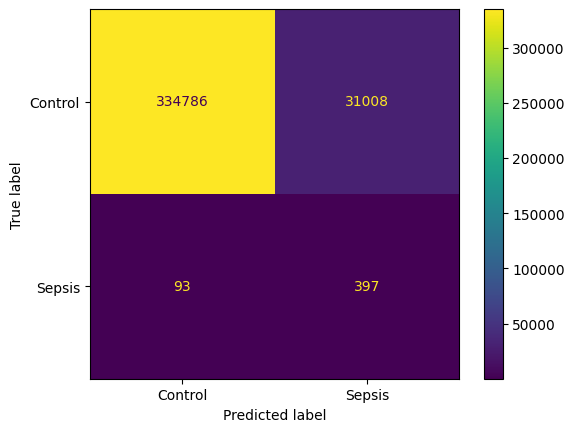

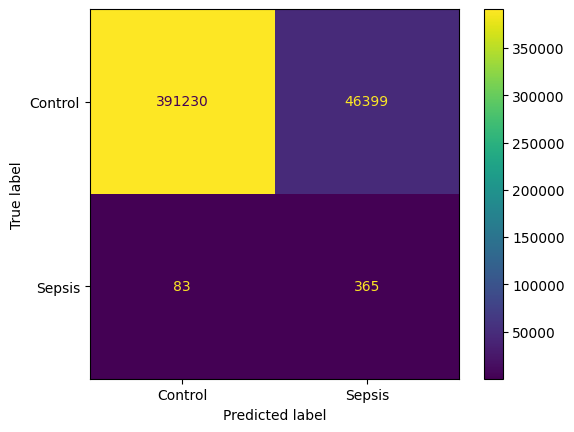

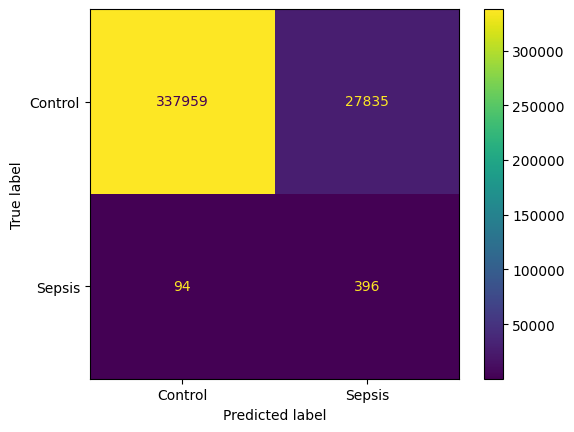

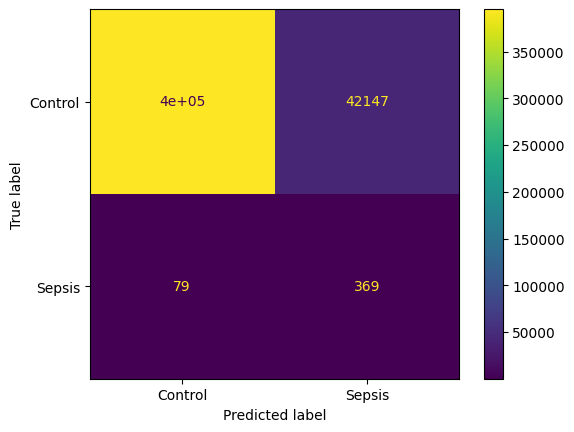

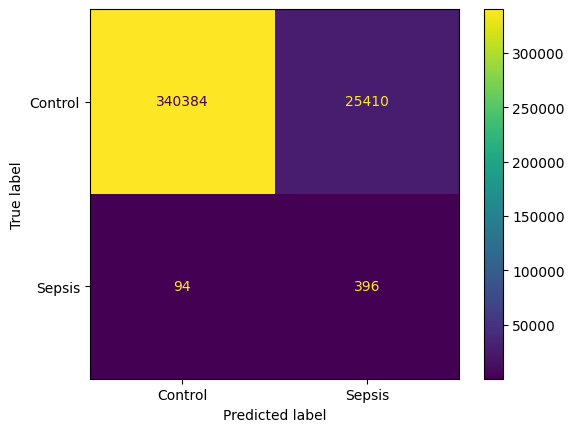

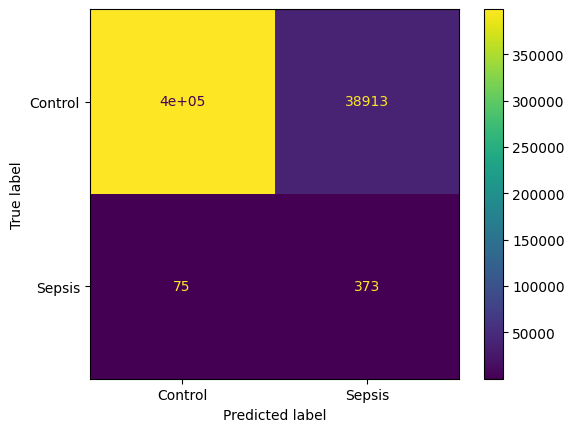

In [116]:
from dataAnalysis.Metrics import Evaluation
dfs = []
for model in models:
    model = model.cpu()
    graph = graph.cpu()
    
    y_dict = Evaluation.create_y_dict(model.predict(graph, test_mask), model.predict_proba(graph, test_mask) , graph.y[test_mask])
    y_dict_gw = Evaluation.create_y_dict(model.predict(graph, test_gw_mask), model.predict_proba(graph, test_gw_mask) , graph.y[test_gw_mask])

    Evaluation.plot_confusion_matrix_from_pred(model.predict(graph, test_mask), graph.y[test_mask])
    Evaluation.plot_confusion_matrix_from_pred(model.predict(graph, test_gw_mask), graph.y[test_gw_mask])
    dfs.append(Evaluation.get_df_metrics_from_pred(y_dict, y_dict_gw))

In [117]:
for df in dfs:
    print(df)

         Name       MCC  F1-Micro  F1-Macro  F1-Binary     AUROC     AUPRC
0     Leipzig  0.096396  0.920119  0.492191   0.026031  0.943578  0.049891
1  Greifswald  0.077740  0.902933  0.482957   0.016968  0.942370  0.032993
         Name       MCC  F1-Micro  F1-Macro  F1-Binary     AUROC     AUPRC
0     Leipzig  0.102335  0.925692  0.494891   0.028414  0.950822  0.049411
1  Greifswald  0.081942  0.907156  0.484714   0.018153  0.948365  0.031418
         Name       MCC  F1-Micro  F1-Macro  F1-Binary     AUROC     AUPRC
0     Leipzig  0.102939  0.927914  0.495773   0.028979  0.948748  0.050159
1  Greifswald  0.081232  0.907678  0.484813   0.018064  0.945904  0.031586
         Name       MCC  F1-Micro  F1-Macro  F1-Binary     AUROC     AUPRC
0     Leipzig  0.102296  0.924908  0.494604   0.028264  0.947737  0.050539
1  Greifswald  0.082129  0.907044  0.484696   0.018179  0.946349  0.034837
         Name      MCC  F1-Micro  F1-Macro  F1-Binary     AUROC     AUPRC
0     Leipzig  0.10221  0.

In [118]:
for i, model in enumerate(models):
    torch.save(model.state_dict(), f"models/rev_directed_gat_without_pos_{i+10}.pt")

## Model back to CPU for evaluation purposes

In [113]:
model = model_wrapper.get_model()
graph = graph.cpu()
model = model.cpu()

In [101]:
torch.save(model.state_dict(), "models/rev_directed_gat_without_pos.pt")

## Evaluation

,Name,MCC,F1-Micro,F1-Macro,F1-Binary,AUROC,AUPRC
0,Leipzig,0.107574,0.931114,0.497547,0.030806,0.952476,0.050657
1,Greifswald,0.084424,0.914643,0.487393,0.019406,0.950063,0.033606


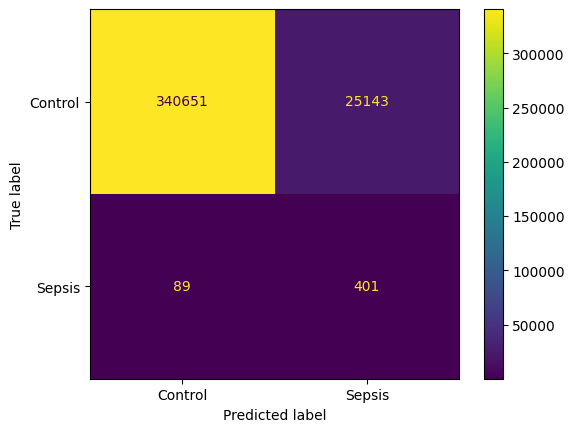

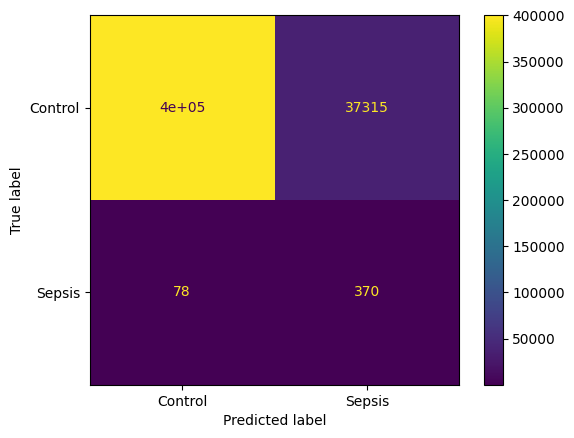

In [114]:
from dataAnalysis.Metrics import Evaluation

y_dict = Evaluation.create_y_dict(model.predict(graph, test_mask), model.predict_proba(graph, test_mask) , graph.y[test_mask])
y_dict_gw = Evaluation.create_y_dict(model.predict(graph, test_gw_mask), model.predict_proba(graph, test_gw_mask) , graph.y[test_gw_mask])

Evaluation.plot_confusion_matrix_from_pred(model.predict(graph, test_mask), graph.y[test_mask])
Evaluation.plot_confusion_matrix_from_pred(model.predict(graph, test_gw_mask), graph.y[test_gw_mask])
Evaluation.get_df_metrics_from_pred(y_dict, y_dict_gw)